## Распознавание эмоций по тексту

Датасет был найден на сайте Kaggle. Ссылка на датасет - https://www.kaggle.com/datasets/shreejitcheela/text-emotion-recognition

В данной части проекта будет реализована бинарная классификация вместо многоклассовой по ряду причин:
1) сложность в нахождении хорошего датасета с текстовыми данными и различными лейблами эмоций
2) определение эмоции человека по переписке - довольно сложный процесс даже для человека. Не всегда есть возможность даже сделать вывод о том, в хорошем или плохом состоянии собеседник. Следовательно, определение более сложных эмоций, таких как страх, грусть или радость - еще более трудная задача
3) Для реализации такого алгоритма потребуются как более глубокие знания в области NLP - анализа текстов, так и большие, качественные данные для тренировки и огромные вычислительные мощности

In [35]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

import warnings

import optuna

from tqdm import tqdm

from wordcloud import WordCloud

import re

import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score

from sklearn.model_selection import train_test_split

import pickle

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay

from IPython.utils import io

## Загрузка датасета

In [15]:
full_data_path = fr"C:\projects\Python\ML\DataBases\text_emotions\Text_Emotion.csv"

In [16]:
full_df = pd.read_csv(full_data_path)
full_df

,text,emotion
0,carefully word blog posts amount criticism hea...,☹️
1,cannot remember little mermaid feeling carefre...,🙂
2,not feeling super well turns cold knocked next...,🙂
3,feel honored part group amazing talents,🙂
4,think helping also began feel pretty lonely lo...,☹️
...,...,...
282817,feel honored motivated share world life changi...,🙂
282818,feel like gloaty really delighted,🙂
282819,feel little energetic one day next several day...,🙂
282820,feel work experience fell although fantastic o...,🙂


In [17]:
full_df.emotion[full_df.emotion == '☹️'] = 0
full_df.emotion[full_df.emotion == '🙂'] = 1
full_df

,text,emotion
0,carefully word blog posts amount criticism hea...,0
1,cannot remember little mermaid feeling carefre...,1
2,not feeling super well turns cold knocked next...,1
3,feel honored part group amazing talents,1
4,think helping also began feel pretty lonely lo...,0
...,...,...
282817,feel honored motivated share world life changi...,1
282818,feel like gloaty really delighted,1
282819,feel little energetic one day next several day...,1
282820,feel work experience fell although fantastic o...,1


In [18]:
full_df.emotion = full_df.emotion.astype(int)

In [19]:
# примеры текста отрицательных эмоций
for true_value in full_df[full_df.emotion == 0]['text'].head(5):
    print(true_value)

carefully word blog posts amount criticism hear place coming saudis non saudis goes show feeling discontent lot areas directed towards specific people never swat teams charging conversations
think helping also began feel pretty lonely lot people used enjoy climbing moved really feel like anyone climb hard gym anymore
still feeling exhausted know strength gotten day
feeling extremely ugly right
waiting sun come back school called joey sore throat want summer make lunch love alllllllllllll


In [20]:
# примеры текста положительных эмоций
for true_value in full_df[full_df.emotion == 1]['text'].head(5):
    print(true_value)

cannot remember little mermaid feeling carefree beauty life gets lost somewhere massive piles homework budgeting finances eventually daunting choices life become adult
not feeling super well turns cold knocked next three weeks afterward hotter know head not
feel honored part group amazing talents
feel like pleasant nice around
cannot get feelings not trusting head


Предложения не похожи на написанные человеком. Они не являются полноценными. Слова идут обрывками и полный смысл предложения не понятен.

### Гипотеза: текст уже был предобработан

In [21]:
def remove_punctuation(text):
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])

def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text])

def remove_multiple_spaces(text):
  """удаление специальных символов"""
  return re.sub(r'\s+', ' ', text, flags=re.I)

In [22]:
english_stop_words = stopwords.words('english')
snowball = SnowballStemmer(language='english')

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(sentence.lower())))]
    prep_text = ' '.join(prep_text)
    
    tokens = word_tokenize(prep_text, language = 'english')
    if remove_stop_words:
        tokens = [i for i in tokens if i not in english_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [23]:
for true_value in full_df[full_df.emotion == 1]['text'].head(10):
    print(len(true_value.split()), len(tokenize_sentence(true_value)))

22 21
15 13
6 6
5 5
6 4
5 4
5 5
10 9
5 5
19 18


до обработки

In [24]:
text_length = full_df.text.apply(len).to_list()  # длины строк с текстом
text_word_amout = []  # количество слов в тексте (важно, тк при обработке происходит еще и стемминг)
for i in full_df.text:
    text_word_amout += [len(i.split())]

обработка

In [25]:
english_stopwords = stopwords.words("english")

In [26]:
prep_texts = []
for t in tqdm(full_df.text):
    prep_texts.append(' '.join(tokenize_sentence(t)))

100%|██████████| 282822/282822 [00:28<00:00, 10100.06it/s]


после обработки

In [27]:
full_df['prep_text'] = prep_texts
full_df

,text,emotion,prep_text
0,carefully word blog posts amount criticism hea...,0,care word blog post amount critic hear place c...
1,cannot remember little mermaid feeling carefre...,1,rememb littl mermaid feel carefre beauti life ...
2,not feeling super well turns cold knocked next...,1,feel super well turn cold knock next three wee...
3,feel honored part group amazing talents,1,feel honor part group amaz talent
4,think helping also began feel pretty lonely lo...,0,think help also began feel pretti lone lot peo...
...,...,...,...
282817,feel honored motivated share world life changi...,1,feel honor motiv share world life chang gift a...
282818,feel like gloaty really delighted,1,feel like gloati realli delight
282819,feel little energetic one day next several day...,1,feel littl energet one day next sever day hard...
282820,feel work experience fell although fantastic o...,1,feel work experi fell although fantast opportu...


In [28]:
text_length2 = full_df.prep_text.apply(len).to_list()
text_word_amout2 = []  # количество слов в тексте (важно, тк при обработке происходит еще и стемминг)
for i in full_df.text:
    text_word_amout2 += [len(i.split())]

In [29]:
mean_len_diff = np.mean([abs(text_length2[i] - text_length[i]) for i in range(len(text_length))])
mean_amount_diff = np.mean([abs(text_word_amout2[i] - text_word_amout[i]) for i in range(len(text_word_amout))])

In [30]:
print(f'средняя разница длин строк до и после обработки: {mean_len_diff}')
print(f'средняя разница количества слов в строках до и после обработки: {mean_amount_diff}')

средняя разница длин строк до и после обработки: 8.757479969733613
средняя разница количества слов в строках до и после обработки: 0.0


Вывод: текст скорее всего уже был обработан по двум причинам: средняя разница количества слов в строках до и после обработки равна 0, предложения являются несвязными. Но обработка была другая, возможно, с использованием других библиотек. Обработка была неполной. К примеру, не был сделан стемминг и лемматизация

Основываясь на том, что гипотеза не была точно подтверждена или опровергнута, будут созданы несколько вариантов датасета: 
1) удаление специальных символов, чисел и пунктуации, стоп слов
2) удаление специальных символов, чисел и пунктуации, стоп слов + стемминг

В датасете не будет изначально проведена лемматизация, потому что это очень времязатратный процесс. Выдвигается новая гипотеза: отсутствие лемматизации не скажется на качестве модели.

## Создание датасета с различными степенями обработки данных

полностью обработанный датасет уже создан, просто переименовываем столбец с ним

In [34]:
# второй вариент датасета
full_df.columns = full_df.columns[:-1].to_list() + ['full_prep_text']

In [37]:
def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(sentence.lower())))]
    prep_text = ' '.join(prep_text)
    
    tokens = word_tokenize(prep_text, language = 'english')
    if remove_stop_words:
        tokens = [i for i in tokens if i not in english_stop_words]
    return tokens

In [40]:
prep_text = [' '.join(tokenize_sentence(text)) for text in full_df.text]

In [42]:
full_df['no_stem_text'] = prep_text

In [43]:
full_df

,text,emotion,full_prep_text,no_stem_text
0,carefully word blog posts amount criticism hea...,0,care word blog post amount critic hear place c...,carefully word blog posts amount criticism hea...
1,cannot remember little mermaid feeling carefre...,1,rememb littl mermaid feel carefre beauti life ...,remember little mermaid feeling carefree beaut...
2,not feeling super well turns cold knocked next...,1,feel super well turn cold knock next three wee...,feeling super well turns cold knocked next thr...
3,feel honored part group amazing talents,1,feel honor part group amaz talent,feel honored part group amazing talents
4,think helping also began feel pretty lonely lo...,0,think help also began feel pretti lone lot peo...,think helping also began feel pretty lonely lo...
...,...,...,...,...
282817,feel honored motivated share world life changi...,1,feel honor motiv share world life chang gift a...,feel honored motivated share world life changi...
282818,feel like gloaty really delighted,1,feel like gloati realli delight,feel like gloaty really delighted
282819,feel little energetic one day next several day...,1,feel littl energet one day next sever day hard...,feel little energetic one day next several day...
282820,feel work experience fell although fantastic o...,1,feel work experi fell although fantast opportu...,feel work experience fell although fantastic o...


In [51]:
full_df.dropna(inplace=True)

## Промежуточное сохранение
чтобы каждый раз не делать обработку, а просто загружать готовый датасет

In [52]:
full_df.to_csv('full_dataset_emotions_text.csv', index=False)

In [57]:
full_df = pd.read_csv('full_dataset_emotions_text.csv')

## Распределение длины текста

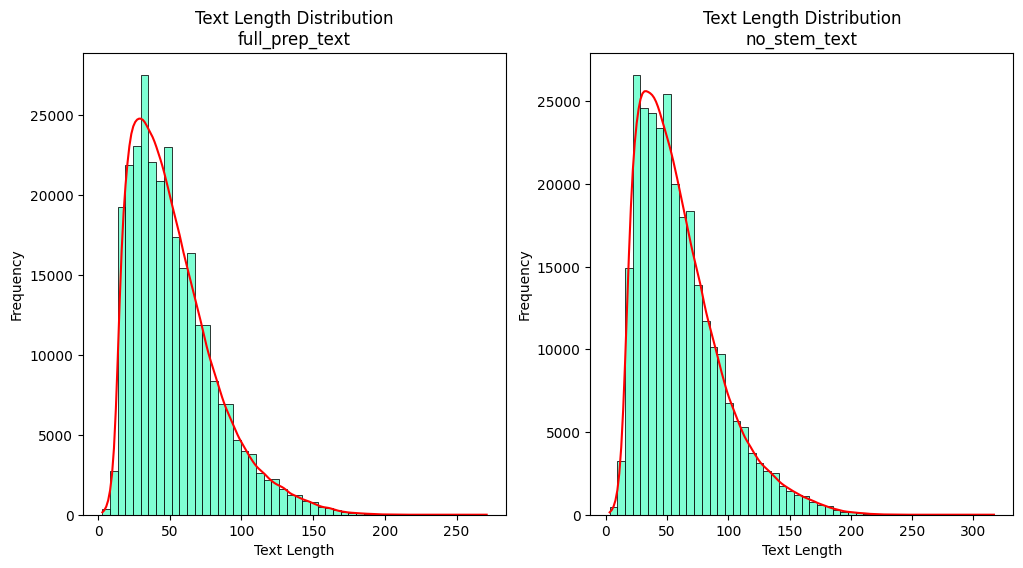

In [54]:
f, axes = plt.subplots(1, 2)
f.set_figheight(6)
f.set_figwidth(12)

columns = full_df.columns.to_numpy()[2:]
for i, (column, ax) in enumerate(zip(columns, axes)):
    text_length = full_df[column].apply(len)
    sns.histplot(text_length, bins=50, color='red', kde=True, facecolor='aquamarine', ax=ax)
    ax.set_title(f'Text Length Distribution\n{column}')
    ax.set_xlabel('Text Length')
    ax.set_ylabel('Frequency')

Как показано на графике, распределение длины текста практически не отличается. Это еще раз доказывает предобработанное начало датасета

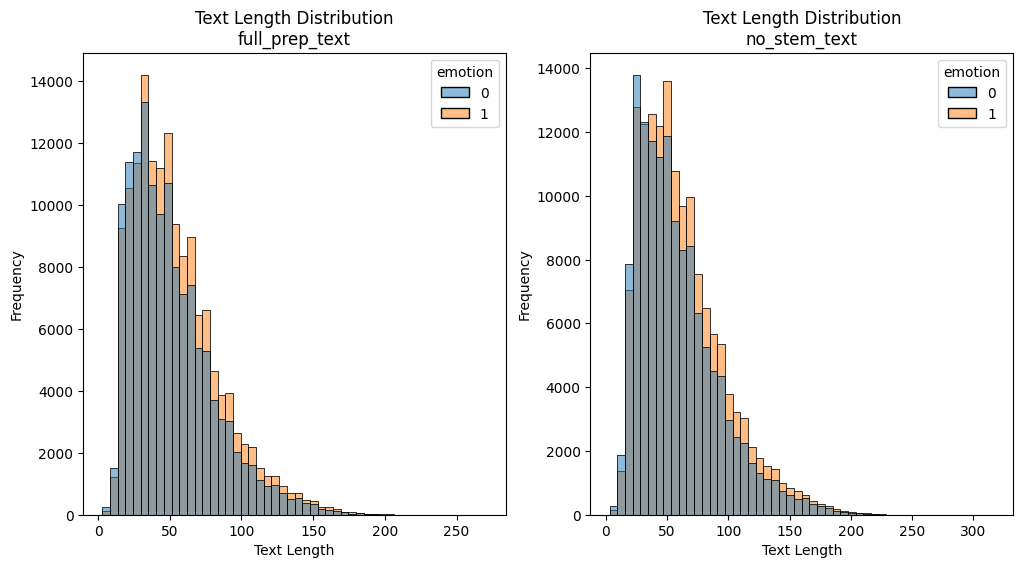

In [63]:
f, axes = plt.subplots(1, 2)
f.set_figheight(6)
f.set_figwidth(12)

df = full_df.copy()

columns = full_df.columns.to_numpy()[2:]
for i, (column, ax) in enumerate(zip(columns, axes)):
    df['length'] = df[column].apply(len)
    sns.histplot(data=df, ax=ax, x='length', hue='emotion', multiple='layer', bins=50)
    ax.set_title(f'Text Length Distribution\n{column}')
    ax.set_xlabel('Text Length')
    ax.set_ylabel('Frequency')

Данные графики показывают, что в датасете у эмоций одинаковое распределение длин текста, что свидетельствует об отсутствии значимой зависимости между длиной текста и эмоцией

## WordCloud

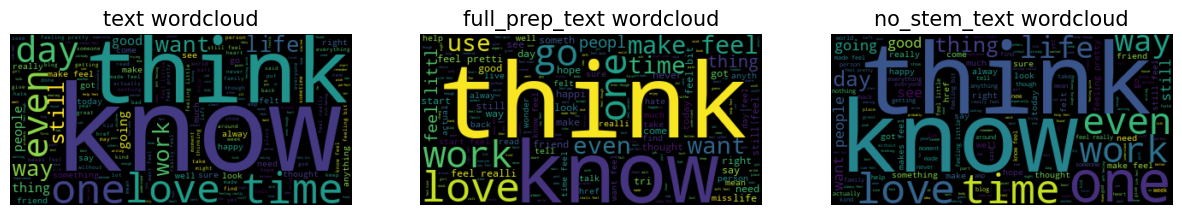

In [65]:
f, axes = plt.subplots(1, 3)
f.set_figheight(10)
f.set_figwidth(15)

columns = full_df.columns.to_numpy()[[0, 2, 3]]
for i, (column, ax) in enumerate(zip(columns, axes)):
    result = set(full_df[column])
    result_text = ' '.join(result)
    wordcloud = WordCloud().generate(result_text)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'{column} wordcloud', fontsize=15)

## Диаграмма распределения классов

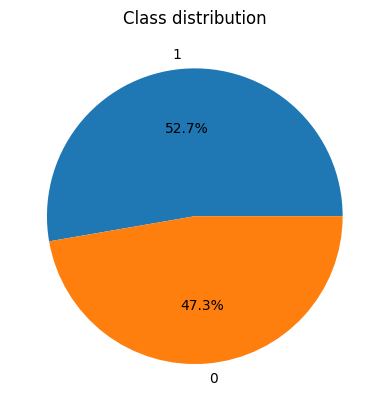

In [66]:
full_df.emotion.value_counts().plot(kind='pie', title='Class distribution', autopct='%1.1f%%')
plt.axis('off')
plt.show()

Распределение классов сбалансировано, следовательно, не нужно делать oversampling/undersampling

## Обучение всех доступных моделей sklearn 

In [28]:
import sys
sys.path.append('C:\projects\Python\ML_TOOLS')

In [32]:
from models_ml import Classifier

Авторский класс предоставляет возможность обучить сразу все доступные внутри модели на тренировочных данных. Во время обучения выводятся информация и предупреждения по каждой модели. Ссылка на проект на гитхабе: https://github.com/egrsid/ML_tools

первый варинт обработки

In [84]:
x_train, x_test, y_train, y_test = train_test_split(full_df.no_stem_text, full_df.emotion, test_size=0.15, random_state=42, stratify=full_df.emotion)

In [85]:
x_train.shape, x_test.shape

((240397,), (42424,))

In [86]:
vectorizer = TfidfVectorizer()
x_train_features = vectorizer.fit_transform(x_train)

In [87]:
x_test_features = vectorizer.transform(x_test)

In [9]:
with open('vectorizers/vect_no_stem_text.pickle', 'wb') as handle:
    pickle.dump(vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
model = Classifier()
fitted_models = model.fit_all(x_train_features, y_train)

!Default models! 

===============BernoulliNB===============
WAS FITTED SUCCESSFULLY

===============CalibratedClassifierCV===============
WAS FITTED SUCCESSFULLY

===============CategoricalNB===============
FITTING FAILED: Sparse data was passed for X, but dense data is required. Use '.toarray()' to convert to a dense numpy array.

===============ClassifierChain===============
FITTING FAILED: ClassifierChain.__init__() missing 1 required positional argument: 'base_estimator'

===============ComplementNB===============
WAS FITTED SUCCESSFULLY

===============DecisionTreeClassifier===============
WAS FITTED SUCCESSFULLY

===============DummyClassifier===============
WAS FITTED SUCCESSFULLY

===============ExtraTreeClassifier===============
WAS FITTED SUCCESSFULLY

===============FixedThresholdClassifier===============
FITTING FAILED: FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'

===============GaussianNB===============
FITTING FAILED: Sparse da

In [11]:
with open('fitted_models/models_no_stem_text.pickle', 'wb') as handle:
    pickle.dump(fitted_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

второй вариант датасета

In [12]:
x_train, x_test, y_train, y_test = train_test_split(full_df.full_prep_text, full_df.emotion, test_size=0.15, random_state=42, stratify=full_df.emotion)

In [13]:
vectorizer = TfidfVectorizer()
x_train_features = vectorizer.fit_transform(x_train)
x_test_features = vectorizer.transform(x_test)

In [14]:
with open('vectorizers/vect_full_prep_text.pickle', 'wb') as handle:
    pickle.dump(vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
model = Classifier()
fitted_models = model.fit_all(x_train_features, y_train)

!Default models! 

===============BernoulliNB===============
WAS FITTED SUCCESSFULLY

===============CalibratedClassifierCV===============
WAS FITTED SUCCESSFULLY

===============CategoricalNB===============
FITTING FAILED: Sparse data was passed for X, but dense data is required. Use '.toarray()' to convert to a dense numpy array.

===============ClassifierChain===============
FITTING FAILED: ClassifierChain.__init__() missing 1 required positional argument: 'base_estimator'

===============ComplementNB===============
WAS FITTED SUCCESSFULLY

===============DecisionTreeClassifier===============
WAS FITTED SUCCESSFULLY

===============DummyClassifier===============
WAS FITTED SUCCESSFULLY

===============ExtraTreeClassifier===============
WAS FITTED SUCCESSFULLY

===============FixedThresholdClassifier===============
FITTING FAILED: FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'

===============GaussianNB===============
FITTING FAILED: Sparse da

In [16]:
with open('fitted_models/models_full_prep_text.pickle', 'wb') as handle:
    pickle.dump(fitted_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Оценка обучения

загрузка данных по первому обучению

In [5]:
with open('fitted_models/models_no_stem_text.pickle', 'rb') as handle:
    fitted_models_no_stem = pickle.load(handle)

In [37]:
with open('vectorizers/vect_no_stem_text.pickle', 'rb') as handle:
    vectorizer_no_stem = pickle.load(handle)

In [7]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(full_df.no_stem_text, full_df.emotion, test_size=0.15, random_state=42, stratify=full_df.emotion)

In [8]:
x_test_no_stem = vectorizer_no_stem.transform(x_test1)

загрузка данных по второму обучению

In [9]:
with open('fitted_models/models_full_prep_text.pickle', 'rb') as handle:
    fitted_models_full_prep = pickle.load(handle)

In [10]:
with open('vectorizers/vect_full_prep_text.pickle', 'rb') as handle:
    vectorizer_full_prep = pickle.load(handle)

In [11]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(full_df.full_prep_text, full_df.emotion, test_size=0.15, random_state=42, stratify=full_df.emotion)

In [12]:
x_test_full_prep = vectorizer_full_prep.transform(x_test2)

### Вывод метрик для каждой обученной модели

RadiusNeighborsClassifier выдает ошибку при попытке построения графика. Ошибка: No neighbors found for test samples array([   0,    2,    4, ..., 9991, 9994, 9996], dtype=int64), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset

Сама ошибка возникает в результате неправильного подбора изначальных параметров. А исходя из того, что модель была обучена на начальных параметрах(нельзя было изменить основываясь на концепции метода fit_all), они не позволяют алгоритму работать корректно. Он просто не может найти соседей в заданном изначально в sklearn радиусе 1. 

Модель с такими погрешностями в работе ни в коем случае не может стать конечным выбором, даже если итоговая точность на определенных данных получилась бы наилучшей. Поэтому данная модель будет просто исключена из тестов

In [14]:
del fitted_models_no_stem['RadiusNeighborsClassifier']
del fitted_models_full_prep['RadiusNeighborsClassifier']

In [193]:
def show_roc_auc(models, x_test, y_test):
    f, axes = plt.subplots(4, 4)
    f.set_figwidth(15)
    f.set_figheight(18)
    f.suptitle('Evaluation of models fitted on no_stem_text', fontsize=20)
    f.tight_layout()
    for i, ax_row in enumerate(axes):
        for (model_name, model), ax in zip(list(models.items())[i*4:], ax_row):
            score = model.predict(x_test)
            RocCurveDisplay.from_predictions(
            y_test,
            score,
            color="darkorange",
            plot_chance_level=True,
            ax=ax
            )
            ax.set_title(model_name)

In [195]:
def show_confusion_matrix(models, x_test, y_test):
    f, axes = plt.subplots(4, 4)
    f.set_figwidth(20)
    f.set_figheight(23)
    f.suptitle('Evaluation of models fitted on no_stem_text', fontsize=20)
    f.tight_layout()
    
    for i, ax_row in enumerate(axes):
        for (model_name, model), ax in zip(list(models.items())[i*4:], ax_row):
            ax.set_title(model_name)
            ConfusionMatrixDisplay.from_estimator(model, x_test, y_test, ax=ax, colorbar=False, cmap='cividis')

In [196]:
def show_report(models, x_test, y_test):
    df = pd.DataFrame()
    for model_name, model in models.items():
        with io.capture_output():  # нужно, чтобы метод report не выводил сообщения о том, какие метрики не удалось посчитать
            pred = model.predict(x_test)
            df[model_name] = model.report(y_test, pred)
    return df

#### Для текста без стемминга

Построение roc_auc кривой

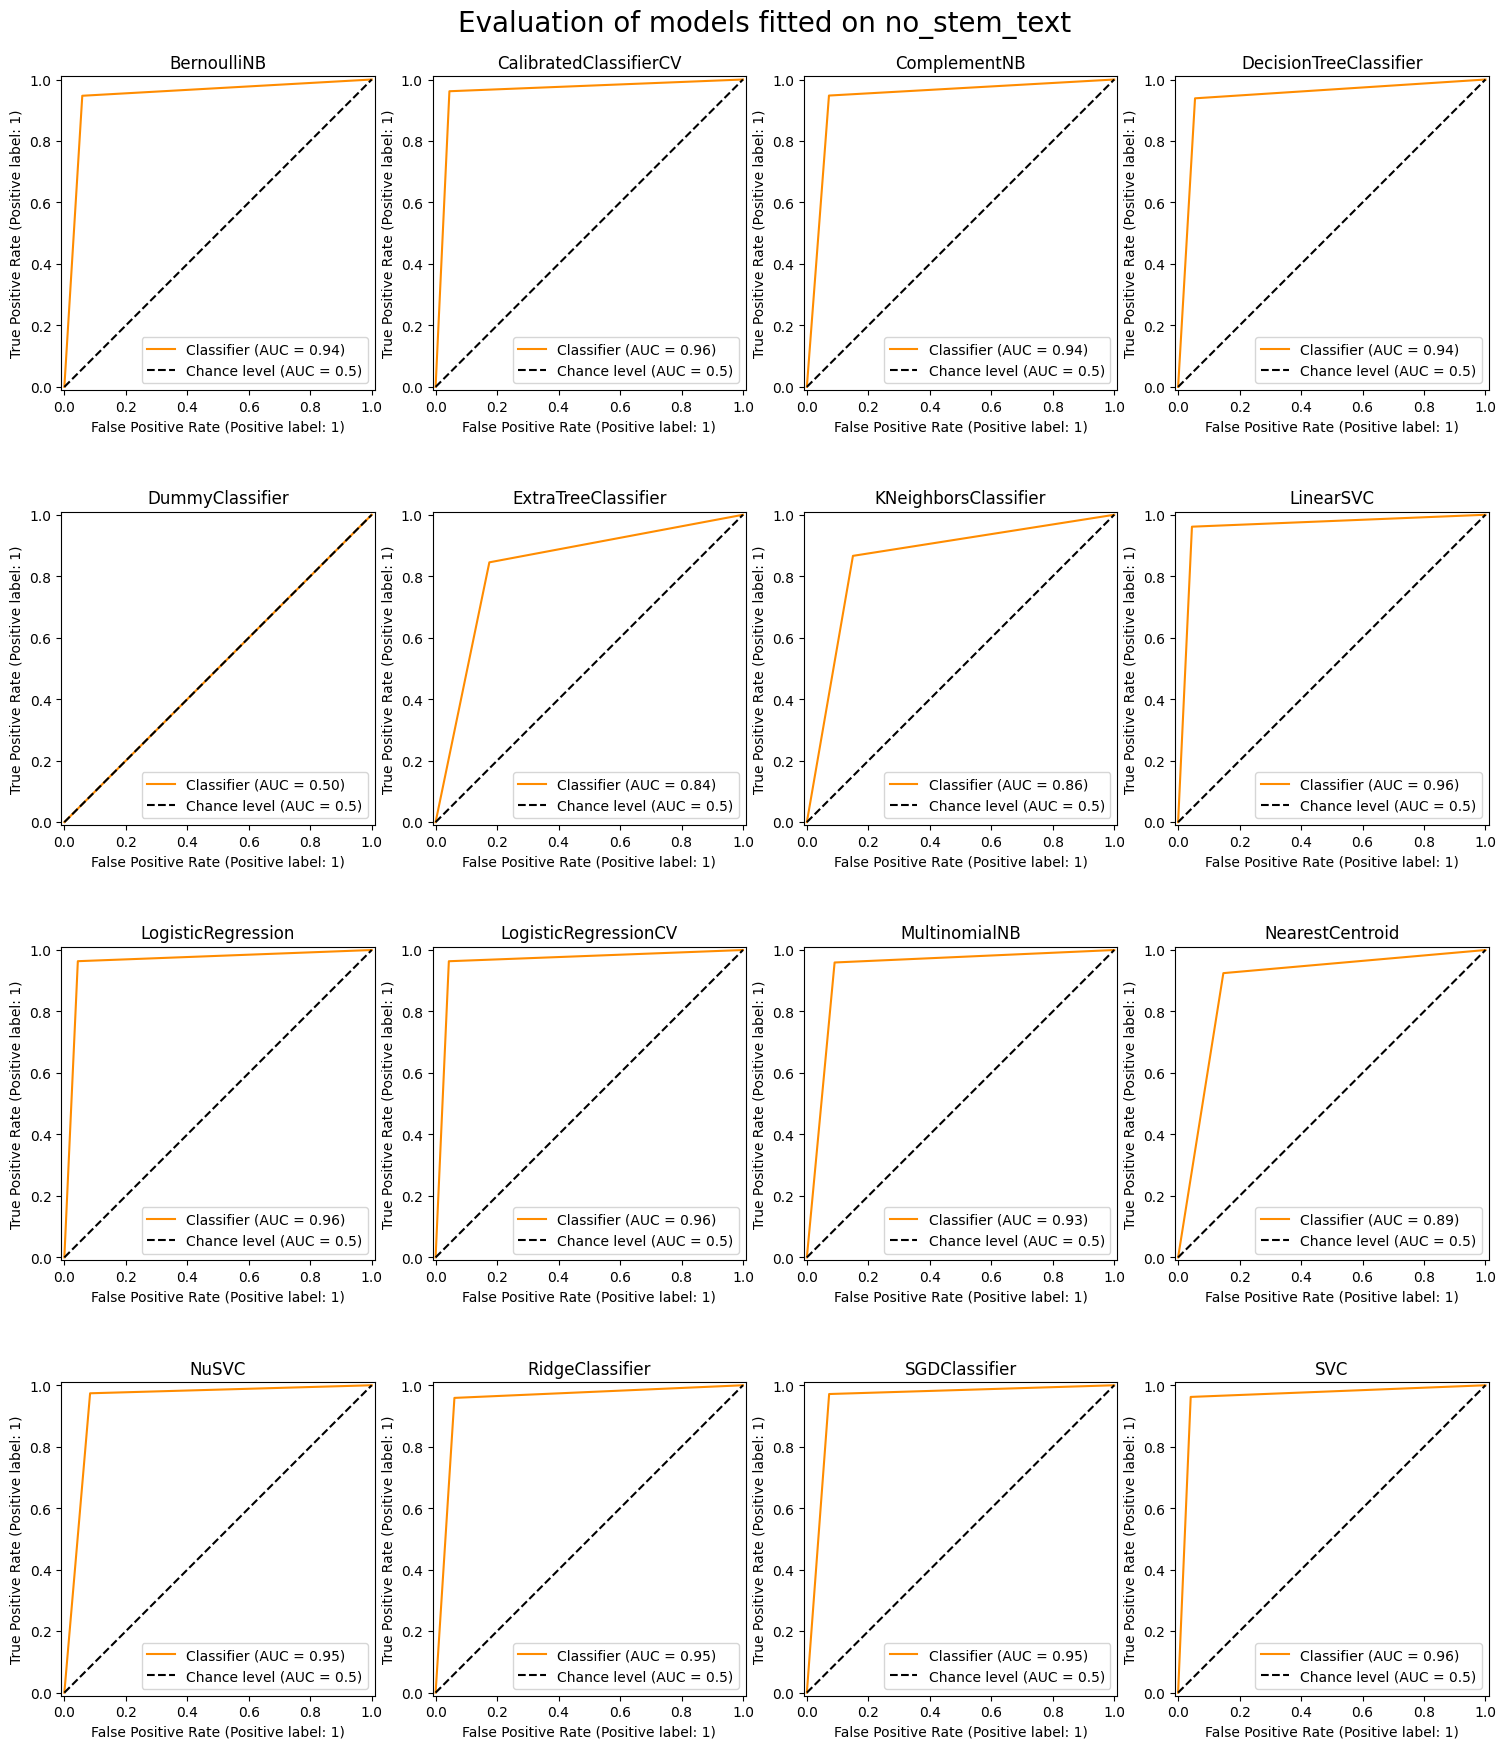

In [197]:
show_roc_auc(fitted_models_no_stem, x_test_no_stem, y_test1)

Вывод матрицы путаницы

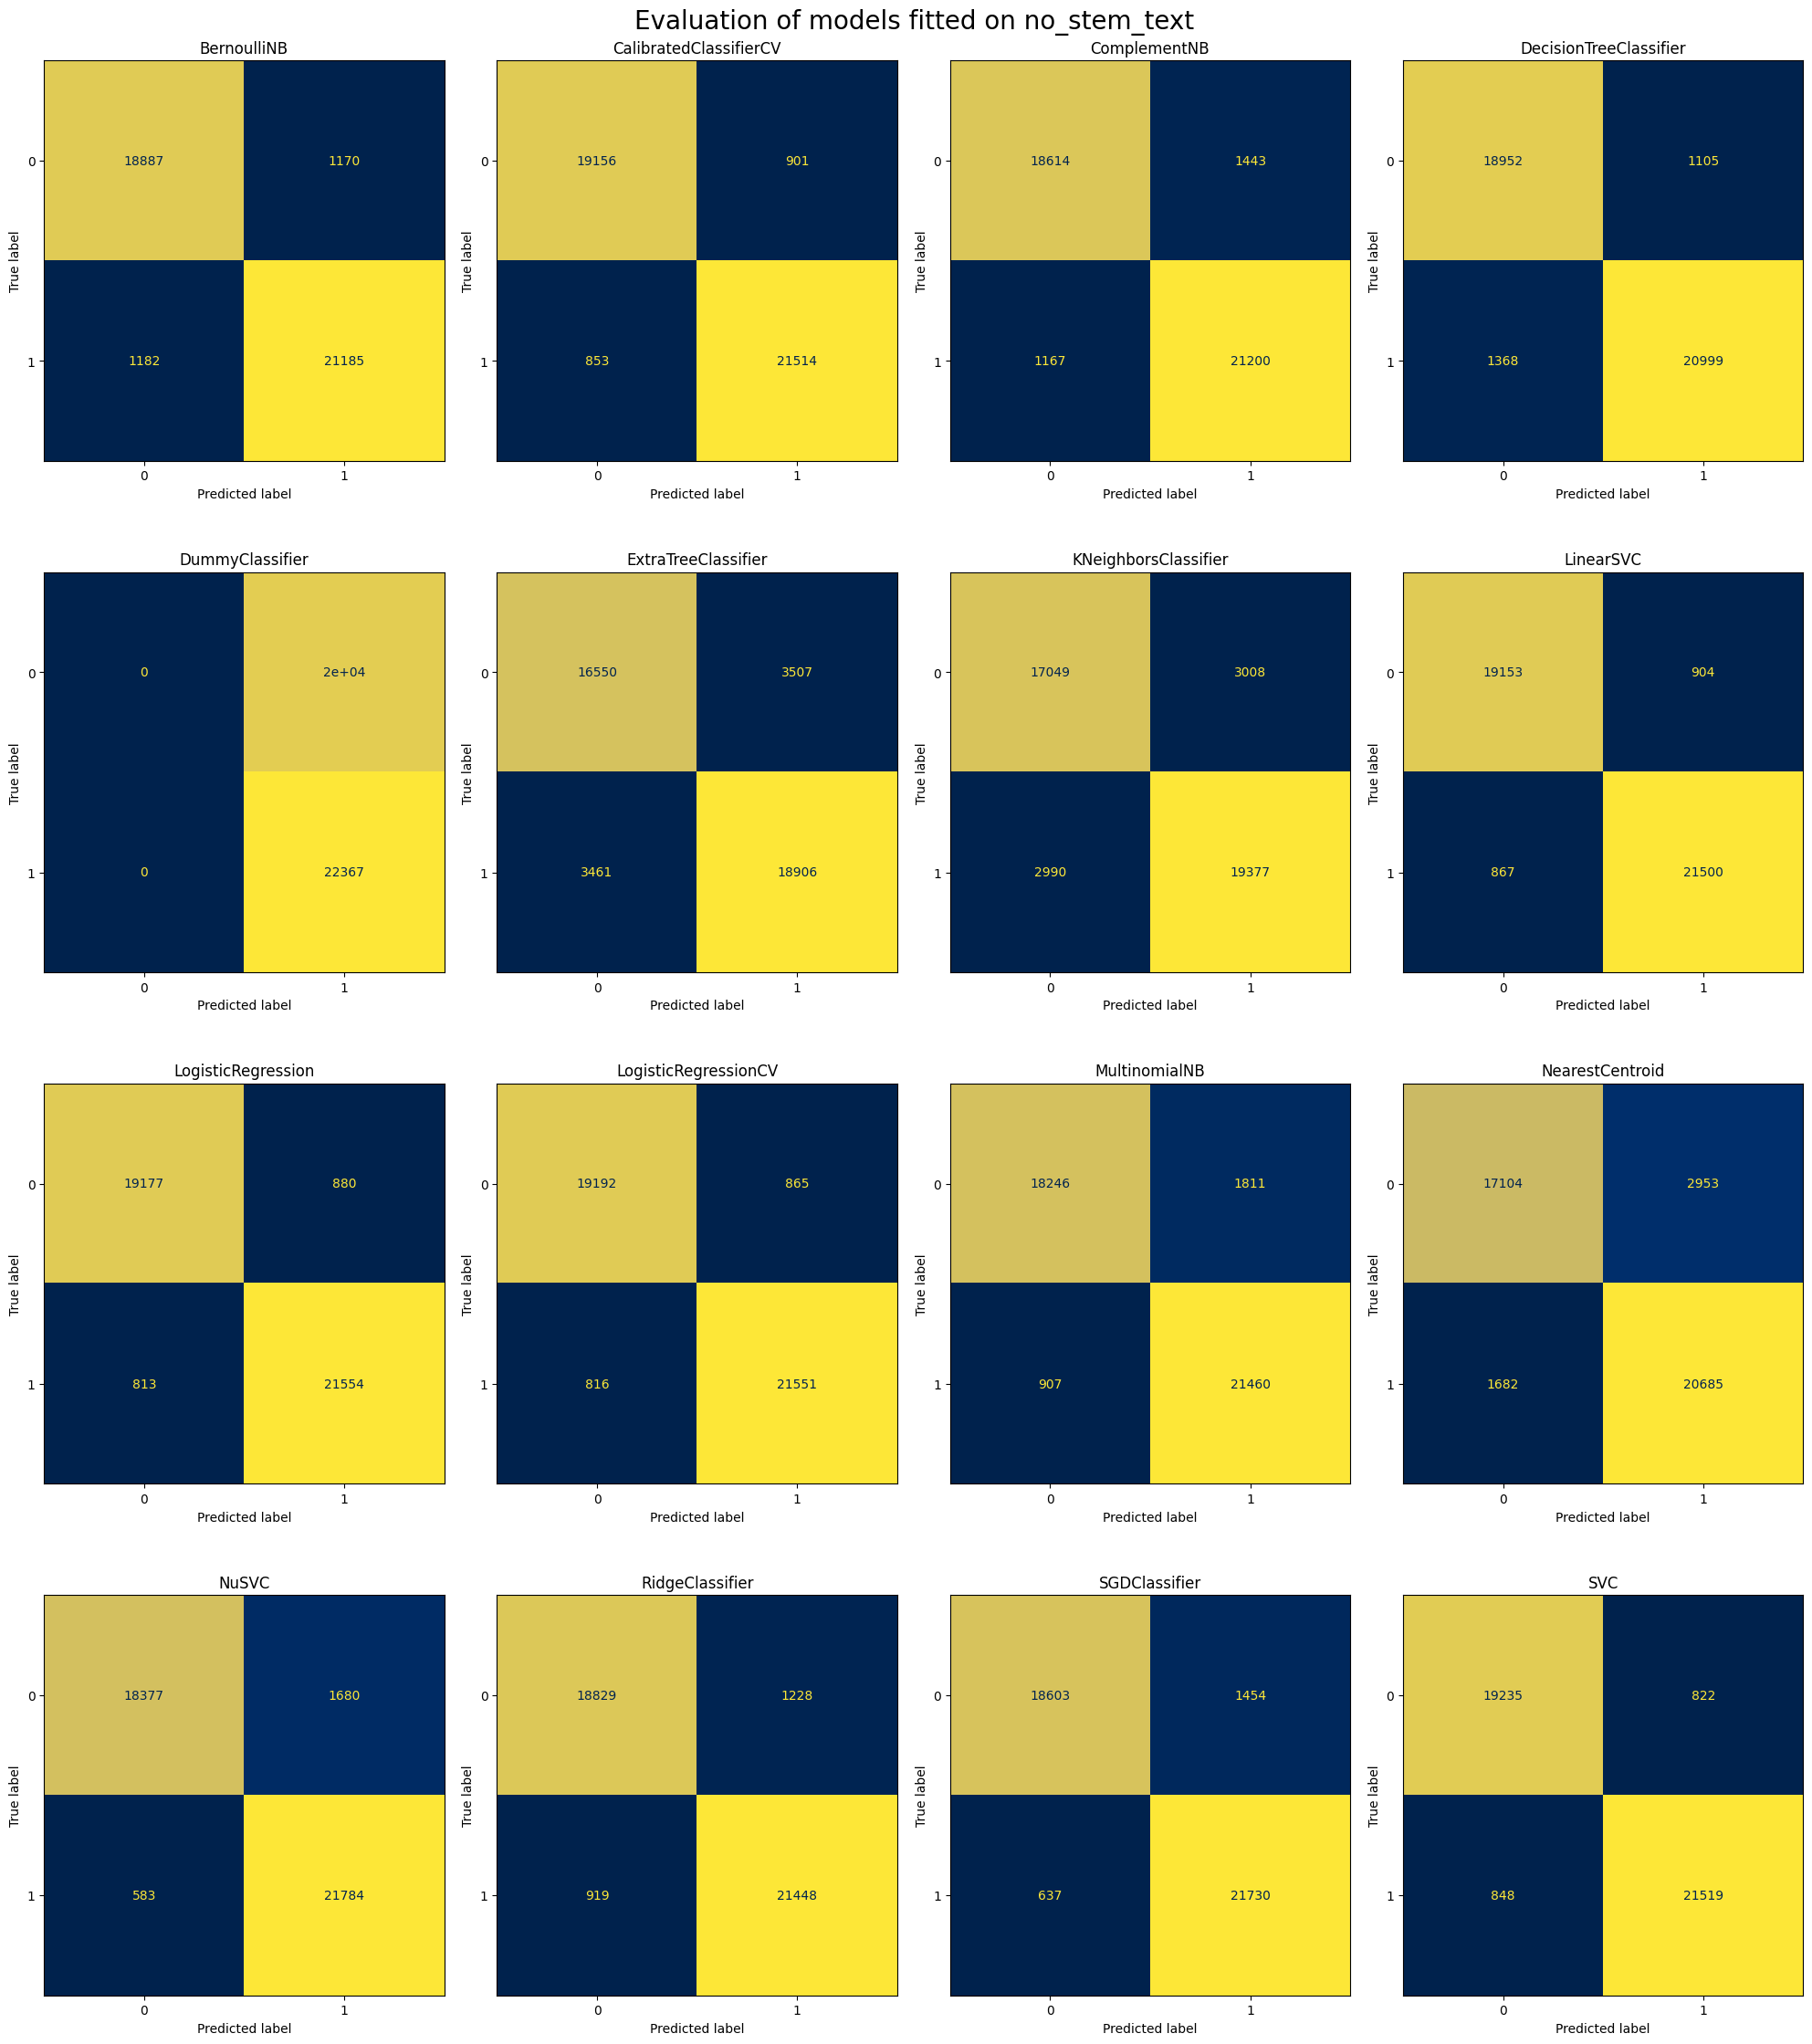

In [198]:
show_confusion_matrix(fitted_models_no_stem, x_test_no_stem, y_test1)

Вывод report

In [199]:
rep_no_stem = show_report(fitted_models_no_stem, x_test_no_stem, y_test1)

In [200]:
rep_no_stem

,BernoulliNB,CalibratedClassifierCV,ComplementNB,DecisionTreeClassifier,DummyClassifier,ExtraTreeClassifier,KNeighborsClassifier,LinearSVC,LogisticRegression,LogisticRegressionCV,MultinomialNB,NearestCentroid,NuSVC,RidgeClassifier,SGDClassifier,SVC
accuracy_score,0.944560,0.958655,0.938478,0.941708,0.527225,0.835753,0.858618,0.958255,0.960093,0.960376,0.935932,0.890746,0.946658,0.949392,0.950712,0.960635
precision_score,0.947663,0.959804,0.936272,0.950009,0.527225,0.843528,0.865624,0.959650,0.960774,0.961411,0.922178,0.875074,0.928401,0.945846,0.937284,0.963207
recall_score,0.947154,0.961863,0.947825,0.938838,1.000000,0.845263,0.866321,0.961238,0.963652,0.963518,0.959449,0.924800,0.973935,0.958913,0.971521,0.962087
f1_score,0.947408,0.960832,0.942013,0.944391,0.690435,0.844395,0.865972,0.960443,0.962211,0.962463,0.940444,0.899250,0.950623,0.952334,0.954095,0.962647
d2_absolute_error_score,0.882734,0.912549,0.869871,0.876701,0.000000,0.652590,0.700952,0.911702,0.915591,0.916189,0.864486,0.768909,0.887172,0.892955,0.895747,0.916737
completeness_score,0.690382,0.751208,0.666664,0.679082,1.000000,0.354663,0.411246,0.749370,0.757821,0.759083,0.661813,0.507321,0.709419,0.711550,0.722464,0.760184
homogeneity_score,0.690413,0.751071,0.665898,0.679670,0.000000,0.354602,0.411218,0.749265,0.757627,0.758942,0.658718,0.503601,0.705149,0.710624,0.719492,0.760256
jaccard_score,0.900072,0.924618,0.890382,0.894640,0.527225,0.730695,0.763626,0.923897,0.927173,0.927643,0.887584,0.816943,0.905893,0.909006,0.912220,0.927983
brier_score_loss,0.055440,0.041345,0.061522,0.058292,0.472775,0.164247,0.141382,0.041745,0.039907,0.039624,0.064068,0.109254,0.053342,0.050608,0.049288,0.039365
d2_tweedie_score,0.777579,0.834130,0.753181,0.766137,-0.896723,0.341060,0.432789,0.832523,0.839899,0.841033,0.742968,0.561684,0.785996,0.796965,0.802261,0.842074


In [207]:
rep_no_stem.to_csv('reports/report_no_stem_text.csv', index=False)

#### Для полностью обработанного текста

построение roc_auc кривой

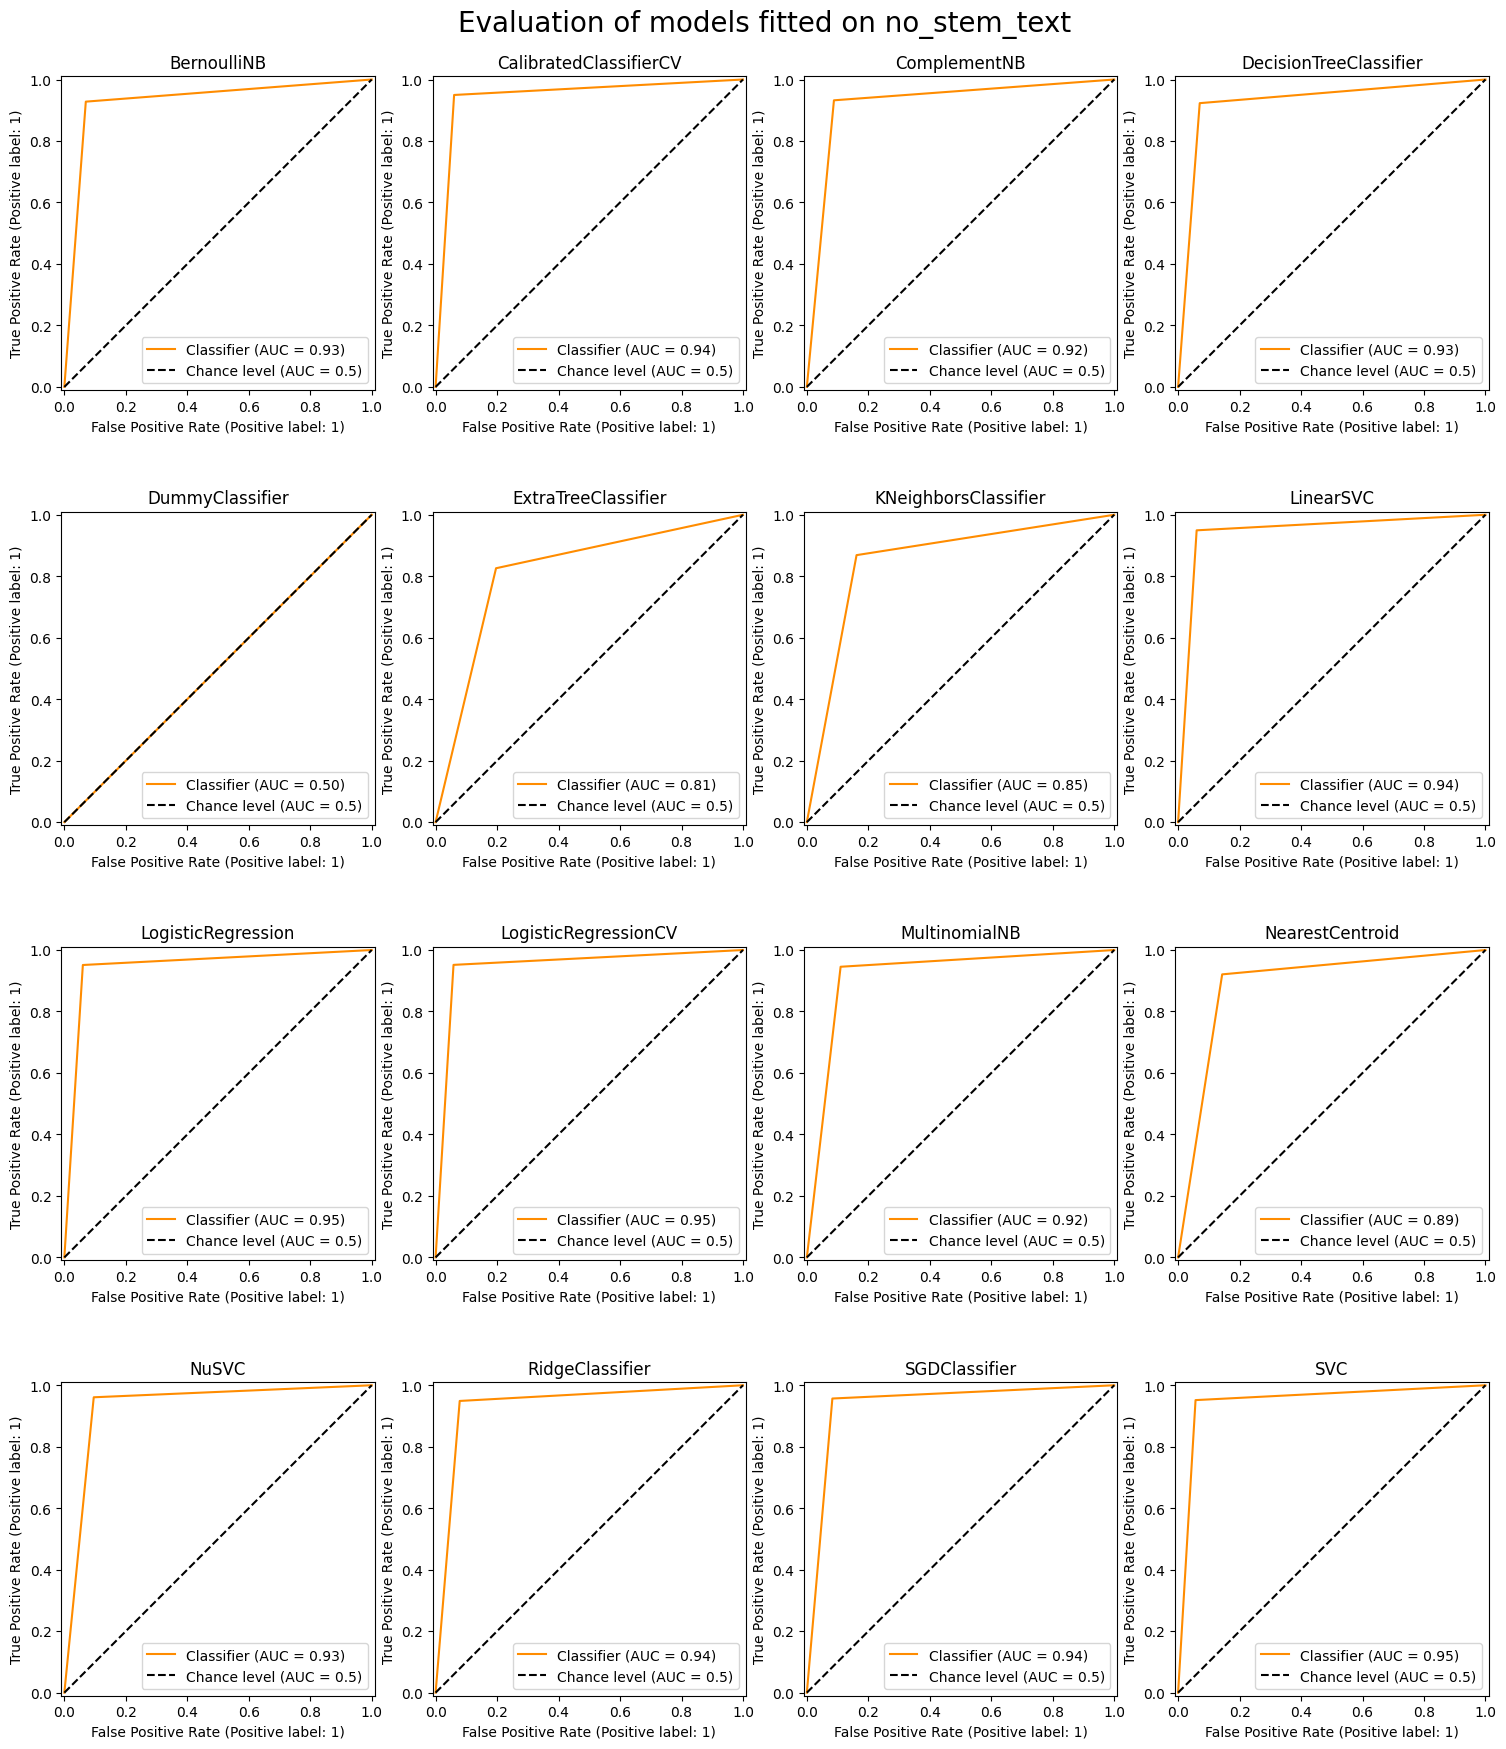

In [201]:
show_roc_auc(fitted_models_full_prep, x_test_full_prep, y_test2)

Вывод матрицы путаницы

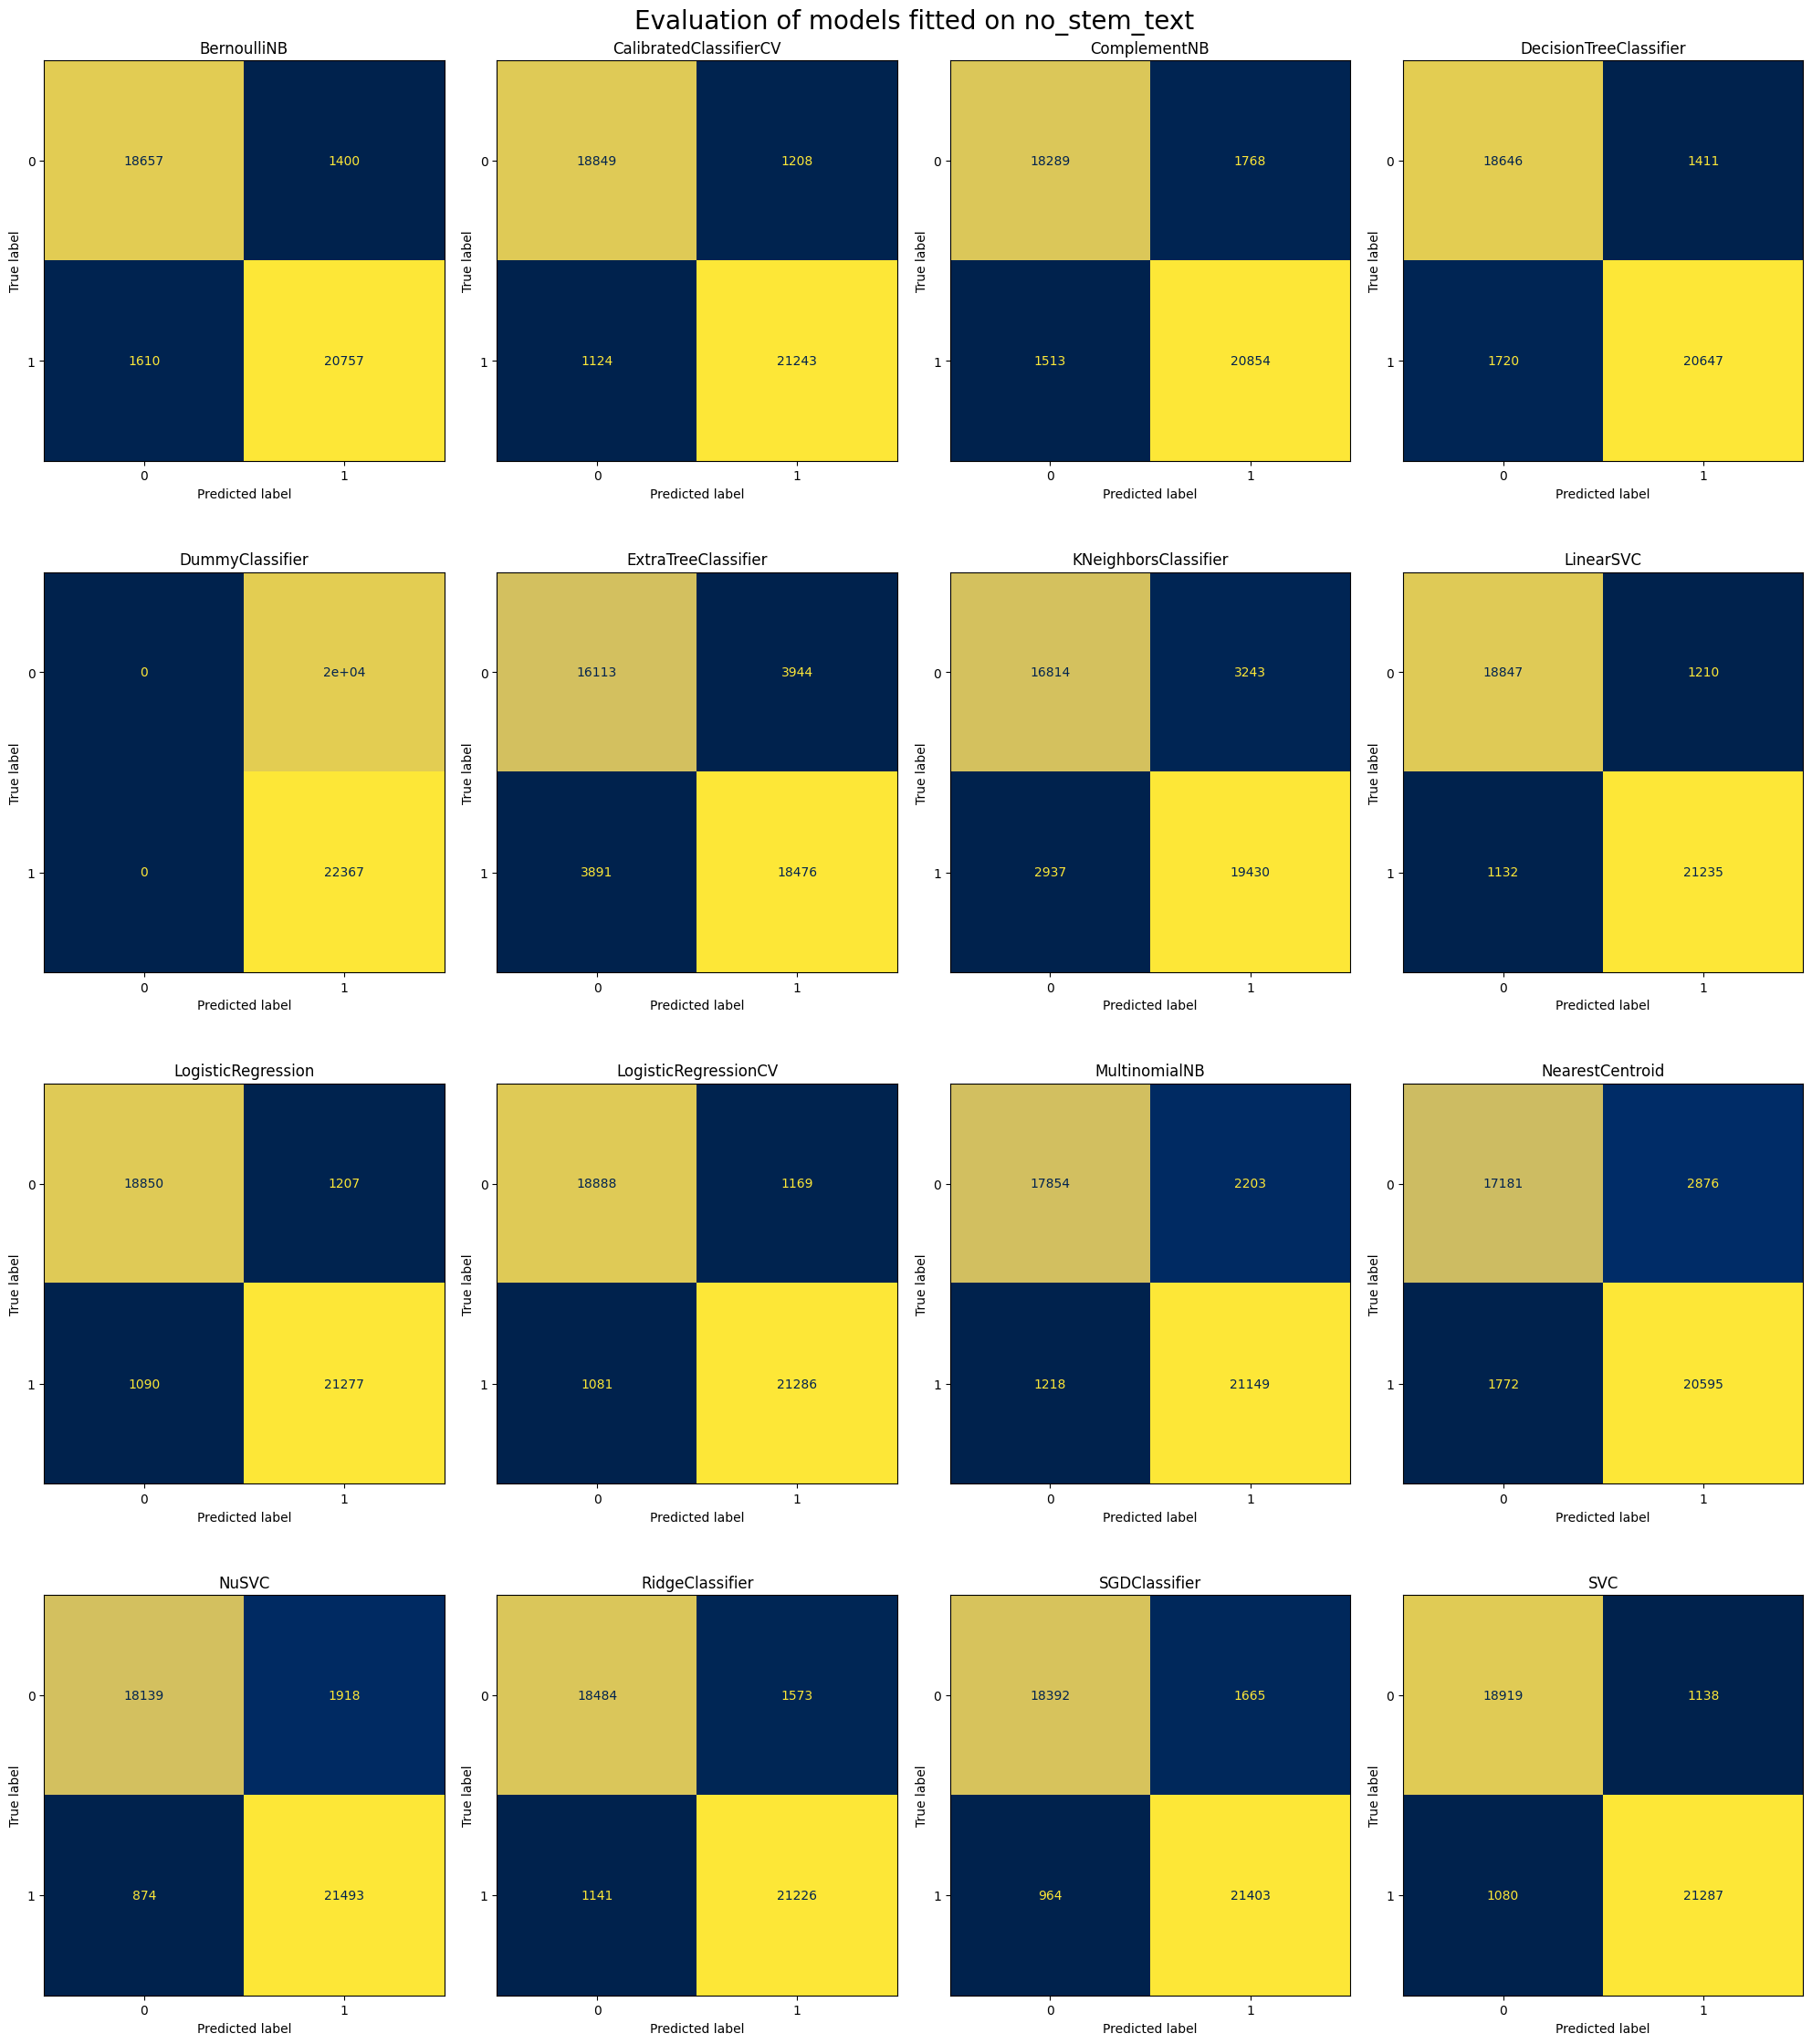

In [202]:
show_confusion_matrix(fitted_models_full_prep, x_test_full_prep, y_test1)

Вывод report

In [208]:
rep_full_prep = show_report(fitted_models_full_prep, x_test_full_prep, y_test2)

In [209]:
rep_full_prep

,BernoulliNB,CalibratedClassifierCV,ComplementNB,DecisionTreeClassifier,DummyClassifier,ExtraTreeClassifier,KNeighborsClassifier,LinearSVC,LogisticRegression,LogisticRegressionCV,MultinomialNB,NearestCentroid,NuSVC,RidgeClassifier,SGDClassifier,SVC
accuracy_score,0.929050,0.945031,0.922662,0.926197,0.527225,0.815317,0.854328,0.944795,0.945856,0.946964,0.919362,0.890439,0.934188,0.936027,0.938030,0.947718
precision_score,0.936815,0.946194,0.921846,0.936032,0.527225,0.824086,0.856966,0.946090,0.946317,0.947940,0.905661,0.877466,0.918073,0.931006,0.927822,0.949253
recall_score,0.928019,0.949747,0.932356,0.923101,1.000000,0.826038,0.868690,0.949390,0.951267,0.951670,0.945545,0.920776,0.960925,0.948987,0.956901,0.951715
f1_score,0.932396,0.947967,0.927071,0.929522,0.690435,0.825061,0.862789,0.947737,0.948786,0.949801,0.925173,0.898599,0.939010,0.939911,0.942137,0.950482
d2_absolute_error_score,0.849928,0.883731,0.836416,0.843895,0.000000,0.609363,0.691878,0.883233,0.885476,0.887820,0.829436,0.768260,0.860797,0.864686,0.868924,0.889415
completeness_score,0.630023,0.692446,0.607074,0.619720,1.000000,0.308780,0.400374,0.691465,0.695924,0.700455,0.600125,0.504968,0.656732,0.657854,0.667904,0.703548
homogeneity_score,0.630469,0.692222,0.606435,0.620336,0.000000,0.308718,0.399859,0.691258,0.695606,0.700218,0.596989,0.501903,0.653029,0.656601,0.665635,0.703392
jaccard_score,0.873354,0.901082,0.864056,0.868324,0.527225,0.702216,0.758688,0.900666,0.902562,0.904402,0.860765,0.815870,0.885032,0.886633,0.890604,0.905637
brier_score_loss,0.070950,0.054969,0.077338,0.073803,0.472775,0.184683,0.145672,0.055205,0.054144,0.053036,0.080638,0.109561,0.065812,0.063973,0.061970,0.052282
d2_tweedie_score,0.715354,0.779471,0.689727,0.703912,-0.896723,0.259070,0.415578,0.778525,0.782780,0.787225,0.676488,0.560454,0.735970,0.743346,0.751384,0.790251


In [210]:
rep_full_prep.to_csv('reports/report_full_prep_text.csv', index=False)

загрузка репортов

In [82]:
rep_full_prep = pd.read_csv('reports/report_full_prep_text.csv')
rep_no_stem= pd.read_csv('reports/report_no_stem_text.csv')

Анализируя полученные графики, репорты и матрицы путаницы, становится понятно, что модели лучше обучаются на данных без стемминга. Следующая задача - определить лучшую модель из представленных. Явными лидерами являются LogisticRegression, LogisticRegressionCV и SVC. Выведем их метрики отдельно

Исходя из того, что модели без стемминга обучились лучше, чем со стеммингом, можно сделать вывод, что лемминг делать не нужно. Следовательно изначальная гипотеза подтвердилась

In [100]:
useful_cols = ['LogisticRegression', 'LogisticRegressionCV', 'SVC']
res_df = rep_no_stem[useful_cols]
res_df

,LogisticRegression,LogisticRegressionCV,SVC
metric,,,
accuracy_score,0.960093,0.960376,0.960635
precision_score,0.960774,0.961411,0.963207
recall_score,0.963652,0.963518,0.962087
f1_score,0.962211,0.962463,0.962647
d2_absolute_error_score,0.915591,0.916189,0.916737
completeness_score,0.757821,0.759083,0.760184
homogeneity_score,0.757627,0.758942,0.760256
jaccard_score,0.927173,0.927643,0.927983
brier_score_loss,0.039907,0.039624,0.039365


Метрики данных моделей практически не отличаются, однако SVC значительно дольше обучается и делает предсказания на данных большого объема. Текстовые данные таковыми и являются. Это происходит за счет сложности модели SVC. LinearRegressionCV является линейной моделью, а следователно быстрее обучается и делает предсказания за счет более простой архитектуры

### Подбор гиперпараметров для модели LogisticRegressionCV

In [17]:
x_train, x_test, y_train, y_test = train_test_split(full_df.text, full_df.emotion, test_size=5000, random_state=42, stratify=full_df.emotion)

функция для обработки текста

In [38]:
def remove_punctuation(text):
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])

def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text])

def remove_multiple_spaces(text):
  """удаление специальных символов"""
  return re.sub(r'\s+', ' ', text, flags=re.I)

In [39]:
english_stop_words = stopwords.words('english')

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(sentence.lower())))]
    prep_text = ' '.join(prep_text)
    
    tokens = word_tokenize(prep_text, language = 'english')
    if remove_stop_words:
        tokens = [i for i in tokens if i not in english_stop_words]
    return tokens

In [169]:
# Функция для оптимизации гиперпараметров
def objective(trial):
    # Параметры для LogisticRegressionCV
    Cs = trial.suggest_categorical('Cs', [5, 10, 20])
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    tol = trial.suggest_float('tol', 1e-4, 1e-2, log=True)
    max_iter = trial.suggest_categorical('max_iter', [1000, 5000, 10000])
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

    # Создаём пайплайн
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(
            tokenizer = lambda x: tokenize_sentence(x, remove_stop_words = True)
        )),
        ('model', LogisticRegressionCV(
            Cs=[Cs],
            penalty=penalty,
            solver=solver,
            tol=tol,
            max_iter=max_iter,
            fit_intercept=fit_intercept,
            class_weight=class_weight,
            cv=5,
            random_state=42,
            verbose=0
        ))
    ])

    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    return recall_score(y_test, y_pred)

# Настройка verbose для Optuna
optuna.logging.set_verbosity(optuna.logging.INFO)

# Создание исследования с направлением на максимизацию
study = optuna.create_study(direction="maximize", study_name="LogisticRegressionCV optimal parameter search")
with warnings.catch_warnings(record=False):
    # Запуск оптимизации на 50 испытаний
    study.optimize(objective, n_trials=50)

# Вывод лучших параметров и метрики
print("\n\nЛучшие параметры:", study.best_params)
print("Лучшая метрика recall:", study.best_value)

[I 2024-09-05 23:35:59,048] A new study created in memory with name: LogisticRegressionCV optimal parameter search
c:\interpreter\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
[I 2024-09-05 23:36:46,631] Trial 0 finished with value: 0.9666160849772383 and parameters: {'Cs': 5, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.007064705006894037, 'max_iter': 10000, 'fit_intercept': False, 'class_weight': None}. Best is trial 0 with value: 0.9666160849772383.
c:\interpreter\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
[I 2024-09-05 23:37:38,182] Trial 1 finished with value: 0.9620637329286799 and parameters: {'Cs': 10, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.0013117052387210649, 'max_iter': 5000, 'fit_intercept': False, 'class_weight': 'balanc



Лучшие параметры: {'Cs': 5, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.007064705006894037, 'max_iter': 10000, 'fit_intercept': False, 'class_weight': None}
Лучшая метрика recall: 0.9666160849772383


In [170]:
with open('model_parameters.pickle', 'wb') as handle:
    pickle.dump(study.best_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
with open('model_parameters.pickle', 'rb') as handle:
    params = pickle.load(handle)

In [41]:
params

{'Cs': 5,
 'penalty': 'l2',
 'solver': 'liblinear',
 'tol': 0.007064705006894037,
 'max_iter': 10000,
 'fit_intercept': False,
 'class_weight': None}

### Создание конечной модели с найденными параметрами обучения

In [42]:
import sys
sys.path.append('C:\projects\Python\ML_TOOLS')

In [43]:
from models_ml import Classifier

In [153]:
model = LogisticRegressionCV()

In [154]:
model_new = model.set_params(**params)

In [155]:
x_train, x_test, y_train, y_test = train_test_split(full_df.text, full_df.emotion, test_size=5000, random_state=42, stratify=full_df.emotion)

In [156]:
model_seq = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize_sentence)),
    ('model', Classifier(model_new))
])

In [157]:
model_seq.fit(x_train, y_train)

c:\interpreter\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tokenize_sentence at 0x0000018C670A4AE0>)),
                ('model', <models_ml.Classifier object at 0x0000018C9588C6D0>)])

In [158]:
result_model = model_seq[1]

In [159]:
predict = model_seq.predict(x_test)

result_model.report(y_test, predict)

Error calculating ndcg_score: Only ('multilabel-indicator', 'continuous-multioutput', 'multiclass-multioutput') formats are supported. Got binary instead
Error calculating dcg_score: Only ('multilabel-indicator', 'continuous-multioutput', 'multiclass-multioutput') formats are supported. Got binary instead
Error calculating fbeta_score: missing a required argument: 'beta'
Error calculating label_ranking_average_precision_score: binary format is not supported


c:\interpreter\Lib\site-packages\sklearn\metrics\_ranking.py:2025: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


{'accuracy_score': 0.9648,
 'precision_score': 0.9648526077097506,
 'recall_score': 0.9685128983308042,
 'f1_score': 0.9666792881484286,
 'd2_absolute_error_score': 0.9255499153976311,
 'completeness_score': 0.7799503158868172,
 'homogeneity_score': 0.7796956499661096,
 'jaccard_score': 0.9355075119091242,
 'brier_score_loss': 0.0352,
 'd2_tweedie_score': 0.8587820853521076,
 'cohen_kappa_score': 0.9293756291989399,
 'd2_pinball_score': 0.9255499153976311,
 'mutual_info_score': 0.5392895716992248,
 'adjusted_mutual_info_score': 0.7797911098734067,
 'average_precision_score': 0.951072195555005,
 'balanced_accuracy_score': 0.9645863984039809,
 'top_k_accuracy_score': 1.0,
 'roc_auc_score': 0.9645863984039807,
 'gini': 0.9291727968079615}

### Отрисовка ROC-AUC кривой

In [160]:
scores = model_seq.predict_proba(x_test)

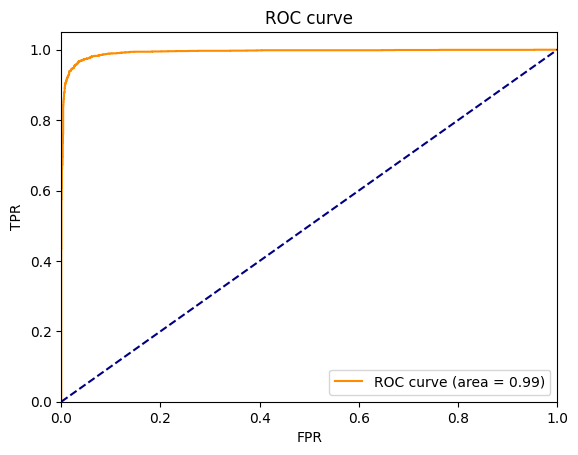

In [161]:
result_model.roc_auc_plot(y_test, scores[:, 1])

### Отрисовка матрицы путаницы

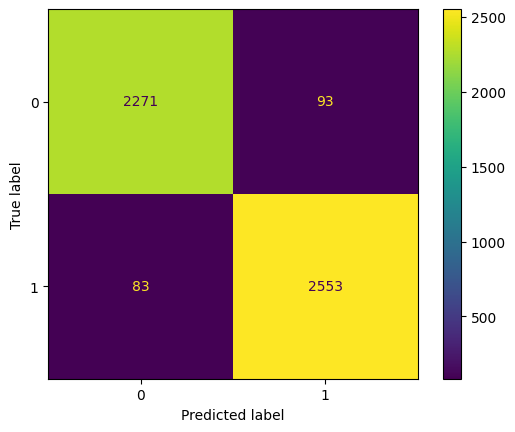

In [162]:
ConfusionMatrixDisplay.from_estimator(model_seq, x_test, y_test);

### Сохранение конечного варианта модели

In [24]:
with open('fitted_models/result_model_pileline.pickle', 'wb') as handle:
    pickle.dump(model_seq, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [67]:
with open('fitted_models/result_model_pileline.pickle', 'rb') as handle:
    model = pickle.load(handle)

In [163]:
messages = ["Switch me to the operator at last, i don't want to talk with your machine",
            "everything was allright",
            "you're the worst operator",
            "WILL SOMEONE ANSWER ME THE RIGHT THING AT LAST ",
            "definetely i will communicate with you one more time with great pleasure"]
true_labels = [0, 1, 0, 0, 1]

In [164]:
predictions = model_seq.predict(messages)
probabilities = model_seq.predict_proba(messages)

In [165]:
for i, pred, proba in zip(range(1, len(true_labels) + 1), predictions, probabilities):
    print(f"{i}) {'true' if pred == true_labels[i-1] else 'false'} predict: {'good' if pred == 1 else 'bad'} mood with probability of {max(proba)}")

1) true predict: bad mood with probability of 0.6459936575114411
2) true predict: good mood with probability of 0.5124614970726279
3) true predict: bad mood with probability of 0.6568672489538081
4) true predict: bad mood with probability of 0.7276843607336685
5) true predict: good mood with probability of 0.8237836313414008


### Выводы:

Была проделана большая работа сразу по нескольким пунктам:
- поиск датасета, который имеет достаточную информативность для обучения модели и необходимые параметры, такие как распределение длин текстов и лейблов
- анализ найденных датасетов и выделение лучшего. В данной работе представлен уже конечный, выбранный мной, лучший датасет
-  подготовка и предобработка данных, которая включает в себя очистку от ненужных символов, выдвижение гипотезы про стемминг и лемминг
-  обучение сразу нескольких моделей для нахождения лучшего варианта
-  выделение лучшей модели, обученной на изначальных параметрах. подбор для нее оптимальных параметров
-  обучение конечной модели на оптимальных параметрах
-  проверка на независимых примерах
  
В результате была достигнута главная цель работы - получение оптимальной модели для бинарной классификации эмоций человека по текстовым сообщениям